In [2]:
library(tidyverse)
library(caret)
library(arrow)
set.seed(123)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘arrow’


The following object is masked from ‘package:lubridate’:

    duration


The following object is masked from ‘package:utils’:

    timestamp




In [3]:
data <- read_parquet('../Dados/Processado/Carros.parquet')

data %>%
    head()

data %>%
    str()

Carro,Marca,Modelo,PrecoMax,PotenciaMotor,TorqueMax,Freios,Tracao,CapacidadeBateria,Autonomia,⋯,PesoMax,CargaMax,NumAssentos,NumPorta,TamanhoPneus,VeloMax,TamanhoPorta-Malas,Aceleracao,PotenciaMaximaBat,ConsumoMedio
<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Audi e-tron 55 quattro,Audi,e-tron 55 quattro,345700,360,664,disc (front + rear),4WD,95,438,⋯,3130,640,5,5,19,200,660,5.7,150,24.45
Audi e-tron 50 quattro,Audi,e-tron 50 quattro,308400,313,540,disc (front + rear),4WD,71,340,⋯,3040,670,5,5,19,190,660,6.8,150,23.80
Audi e-tron S quattro,Audi,e-tron S quattro,414900,503,973,disc (front + rear),4WD,95,364,⋯,3130,565,5,5,20,210,660,4.5,150,27.55
Audi e-tron Sportback 50 quattro,Audi,e-tron Sportback 50 quattro,319700,313,540,disc (front + rear),4WD,71,346,⋯,3040,640,5,5,19,190,615,6.8,150,23.30
Audi e-tron Sportback 55 quattro,Audi,e-tron Sportback 55 quattro,357000,360,664,disc (front + rear),4WD,95,447,⋯,3130,670,5,5,19,200,615,5.7,150,23.85
Audi e-tron Sportback S quattro,Audi,e-tron Sportback S quattro,426200,503,973,disc (front + rear),4WD,95,369,⋯,3130,565,5,5,20,210,615,4.5,150,27.20


tibble [44 × 25] (S3: tbl_df/tbl/data.frame)
 $ Carro             : Factor w/ 53 levels "Audi e-tron 50 quattro",..: 2 1 3 4 5 6 7 8 9 12 ...
 $ Marca             : Factor w/ 20 levels "Audi","BMW","Citroën",..: 1 1 1 1 1 1 2 2 2 4 ...
 $ Modelo            : Factor w/ 53 levels "Citigo-e iV",..: 17 16 18 19 20 21 28 29 34 4 ...
 $ PrecoMax          : num [1:44] 345700 308400 414900 319700 357000 ...
 $ PotenciaMotor     : num [1:44] 360 313 503 313 360 503 170 184 286 136 ...
 $ TorqueMax         : num [1:44] 664 540 973 540 664 973 250 270 400 260 ...
 $ Freios            : Factor w/ 2 levels "disc (front + rear)",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Tracao            : Factor w/ 3 levels "2WD (front)",..: 3 3 3 3 3 3 2 2 2 1 ...
 $ CapacidadeBateria : num [1:44] 95 71 95 71 95 95 42.2 42.2 80 50 ...
 $ Autonomia         : num [1:44] 438 340 364 346 447 369 359 345 460 320 ...
 $ Entre-eixos       : num [1:44] 293 293 293 293 293 ...
 $ Comprimento       : num [1:44] 490 490 490 490 490 ...

# Feature Selection

A feature selection será realizada através do algoritmo Random Forest. Apesar desse algoritmo ser mais utilizado para problemas de classificação e regressão, ele também pode ser utilizado para seleção de features. O algoritmo Random Forest é um algoritmo de ensemble, ou seja, ele utiliza a combinação de vários modelos de árvore de decisão para gerar um modelo final. A vantagem desse algoritmo é que ele é capaz de selecionar as features mais importantes para o modelo, ou seja, as features que mais contribuem para a predição do modelo. No caso em questão, vou selecionar todas as variáveis que possuem uma importância maior que 0.7.

In [4]:
rf_selection_model <- train(
    `ConsumoMedio` ~ .
                    - Carro
                    - Marca
                    - Modelo
                    ,
    data = data,
    method = 'rf'
)

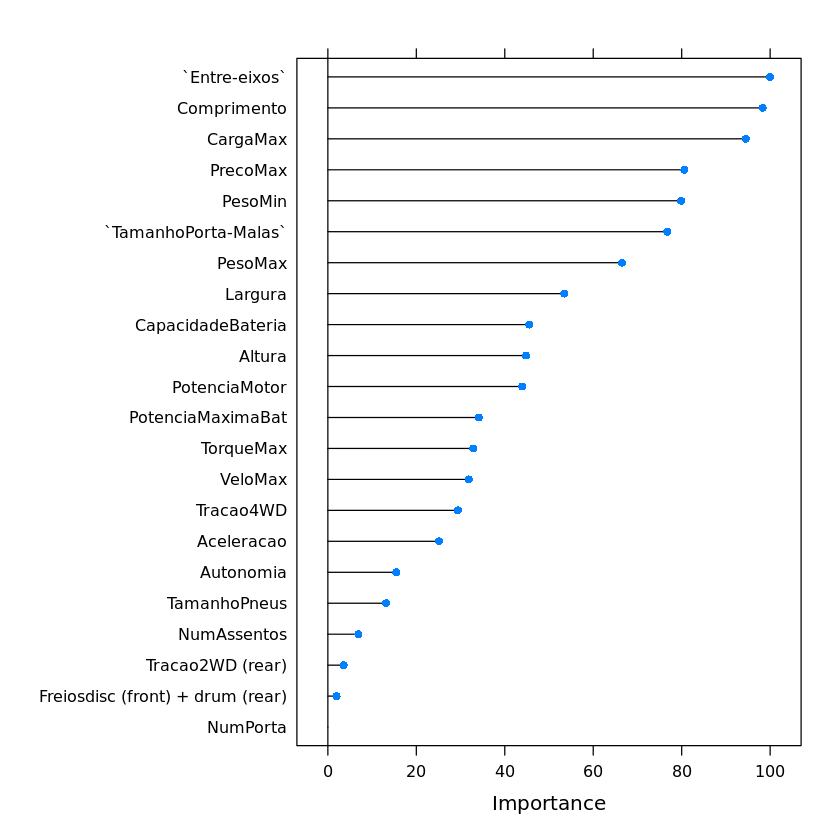

In [5]:
plot(varImp(rf_selection_model))

In [6]:
FORMULA <- 'ConsumoMedio ~ Comprimento + CargaMax + TamanhoPorta-Malas + PrecoMax + PesoMax + PesoMin + Largura'

# Treinamento do Modelo

Como meu objetivo é prever o consumo médio de energia de um carro elétrico, eu me encontro em um problema de regressão. Dessa forma, vou testar alguns algoritmos de regressão e escolher o que apresentar o melhor resultado.

In [7]:
data_split <- createDataPartition(
    y = data$ConsumoMedio,
    p = 0.75,
    list = FALSE
)

train_data <- data[data_split, ]
test_data <- data[-data_split, ]

In [ ]:
%%capture
models <- c('lm', 'rf', 'xgbTree', 'svmRadial', 'knn', 'svmLinear', 'svmLinear3', 'krlsPoly', 'krlsRadial')

model_list <- list()

for (model in models) {
    model_list[[model]] <- train(
        ConsumoMedio ~ Comprimento + CargaMax + `TamanhoPorta-Malas` + PrecoMax + PesoMax + PesoMin + Largura,
        data = train_data,
        method = model,
        preProc = c('center', 'scale'),
        trControl = trainControl(
            method = 'boot',
            number = 25,
            p = 0.80
        )
    )
}

In [9]:
calculate_metrics <- function(model, test_data){
  # Extract model predictions and actual values
  predictions <- predict(model, newdata = test_data)
  actual <- test_data$ConsumoMedio

  # Calculate common regression metrics
  mse <- mean((actual - predictions)^2)
  rmse <- sqrt(mse)
  mae <- mean(abs(actual - predictions))
  r2 <- cor(actual, predictions)^2
  
  #  Dataframe with metrics
  metrics <- data.frame(Model = model$method, MSE = mse, RMSE = rmse, MAE = mae, R2 = r2)
  
  return(metrics)
}


In [10]:
df_metrics <- data.frame()  # Empty dataframe

for(model in model_list){
    temp_df <- calculate_metrics(model, test_data)
    df_metrics <- rbind(df_metrics, temp_df)
}

In [26]:
df_metrics %>%
    arrange(desc(R2))

Model,MSE,RMSE,MAE,R2
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
svmRadial,2.226849,1.492263,1.115563,0.9733828
svmLinear3,2.882738,1.697863,1.550279,0.9723585
svmLinear,4.359512,2.087944,1.781333,0.9710662
lm,3.212528,1.792353,1.515733,0.9691709
rf,2.501950,1.581755,1.302031,0.9649514
krlsRadial,2.135192,1.461230,1.154153,0.9645024
knn,2.420802,1.555893,1.265432,0.9177125
xgbTree,3.566847,1.888610,1.384757,0.8543938
krlsPoly,15.921817,3.990215,3.706352,0.8458158


Retirando os algoritmos de knn, xbgTree e KrlsPoly, que apresentaram resultados muito inferiores, os demais algoritmos todos podem ser escolhidos para o modelo final dependente da situação. Caso esteja em um cenário, por exemplo, que um modelo com um tempo de treinamento mais rápido seja mais importante do que um modelo com um resultado mais preciso e que seja mais fácil de explicar, o de regressão linear pode ser uma boa opção. Dessa forma, a escolha do modelo dependeria do problema de negócio.